<a href="https://colab.research.google.com/github/Luna0216/2025-DL-final-project/blob/main/DL_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets evaluate


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

In [ ]:
train_data = pd.read_csv("train.csv")
train_ptt_data = pd.read_csv("disater_ptt_v2.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train_ptt_data

,text_en,target
0,"West Harbour, south of the 41st country fire, ...",1
1,"Today's wife turns on her home heater, and the...",1
2,"There was a fire in front of the building, and...",1
3,"A fire in the southern part of the country, lo...",1
4,The store next to Mid-Walk Ludlow seems to be ...,1
...,...,...
1239,"When I was riding by the intersection, there w...",1
1240,"Back home from work, Taipei went back to the b...",1
1241,A car crash under the Manchuria Bridge. The wh...,1
1242,"There was a car accident at the intersection, ...",1


In [ ]:
#註記:v2已在搜尋後先過濾長度過長的文章

# #根據原資料EDA結果選出與原資料的長度較相符的資料作訓練，504筆資料
# train_ptt_data["text_en"] = train_ptt_data["text_en"].astype(str)


# word_counts = train_ptt_data["text_en"].str.split().map(len)

# filtered_ptt_data = train_ptt_data[(word_counts >= 10) & (word_counts <= 60)]

In [ ]:
filtered_ptt_data = train_ptt_data.copy()

In [ ]:
filtered_ptt_data = filtered_ptt_data[["text_en", "target"]].rename(columns={"text_en": "text"})
train_ptt_data = filtered_ptt_data[["text", "target"]]


train_merged_data = pd.concat([train_data, train_ptt_data], ignore_index=True)

train_merged_data

,id,keyword,location,text,target
0,1.0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4.0,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5.0,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6.0,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7.0,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
8852,NaN,NaN,NaN,"When I was riding by the intersection, there w...",1
8853,NaN,NaN,NaN,"Back home from work, Taipei went back to the b...",1
8854,NaN,NaN,NaN,A car crash under the Manchuria Bridge. The wh...,1
8855,NaN,NaN,NaN,"There was a car accident at the intersection, ...",1


In [ ]:
!pip install transformers datasets optuna scikit-learn

##EDA

In [ ]:
print('訓練集',train_data)
print('測試集',test_data)

訓練集          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:0

In [ ]:
train_data.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
train_keyword_null = len(train_data[train_data['keyword'].isnull()])
test_keyword_null = len(test_data[test_data['keyword'].isnull()])
train_location_null = len(train_data[train_data['location'].isnull()])
test_location_null = len(test_data[test_data['location'].isnull()])


#location空值偏多，keyword空值不算多
print(f'訓練集keyword為空值的數量：{train_keyword_null}, location為空值的數量:{train_location_null}')
print(f'測試集keyword為空值的數量：{test_keyword_null}, location為空值的數量:{test_location_null}')

訓練集keyword為空值的數量：61, location為空值的數量:2533
測試集keyword為空值的數量：26, location為空值的數量:1105


In [ ]:
train_location_counts = train_data['location'].value_counts(dropna=False)
test_location_counts = test_data['location'].value_counts(dropna=False)
print("\n訓練集常見的 location 值（前10名）：")
print(train_location_counts.head(10))

print("\n測試集常見的 location 值（前10名）：")
print(test_location_counts.head(10))


訓練集常見的 location 值（前10名）：
location
NaN                2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64

測試集常見的 location 值（前10名）：
location
NaN               1105
New York            38
USA                 37
Worldwide           16
United States       15
Canada              13
London              13
United Kingdom      12
Kenya               12
Nigeria             12
Name: count, dtype: int64


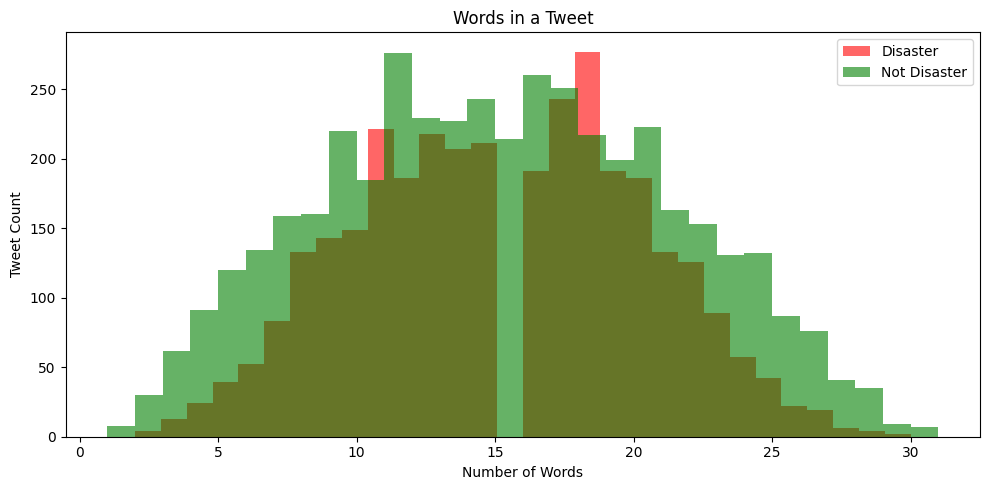

In [ ]:
# 各自詞數（用 str.split() 後取長度）
disaster_words = train_data[train_data['target'] == 1]['text'].str.split().map(len)
not_disaster_words = train_data[train_data['target'] == 0]['text'].str.split().map(len)

# 畫圖
plt.figure(figsize=(10, 5))
plt.hist(disaster_words, bins=30, alpha=0.6, color='red', label='Disaster')
plt.hist(not_disaster_words, bins=30, alpha=0.6, color='green', label='Not Disaster')
plt.title('Words in a Tweet')
plt.xlabel('Number of Words')
plt.ylabel('Tweet Count')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
disaster_words = train_data[train_data['target'] == 1]['text'].str.split().map(len)
not_disaster_words = train_data[train_data['target'] == 0]['text'].str.split().map(len)
disaster_avg = disaster_words.mean()
not_disaster_avg = not_disaster_words.mean()

print(f"災難推文平均詞數：{disaster_avg:.2f} 個詞")
print(f"非災難推文平均詞數：{not_disaster_avg:.2f} 個詞")


災難推文平均詞數：15.17 個詞
非災難推文平均詞數：14.70 個詞


In [ ]:
nltk.download('stopwords')

# 取得英文停用字
stop_words = set(stopwords.words('english'))

# 清理 + 移除停用詞
def clean_and_tokenize(text_series):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text)  # 移除非字母的字元
        words += [word for word in text.split() if word not in stop_words]  # 過濾停用詞
    return words

# 分別處理兩類推文
disaster_words = clean_and_tokenize(train_data[train_data['target'] == 1]['text'])
not_disaster_words = clean_and_tokenize(train_data[train_data['target'] == 0]['text'])

# 各自統計最常見詞
disaster_common = Counter(disaster_words).most_common(20)
not_disaster_common = Counter(not_disaster_words).most_common(20)

print("災難推文最常見的詞（已移除停用詞）：")
for word, count in disaster_common:
    print(f"{word}: {count}")

print("\n非災難推文最常見的詞（已移除停用詞）：")
for word, count in not_disaster_common:
    print(f"{word}: {count}")


災難推文最常見的詞（已移除停用詞）：
fire: 180
news: 140
via: 121
disaster: 117
california: 111
suicide: 110
police: 107
amp: 107
people: 105
killed: 93
like: 92
pm: 89
hiroshima: 89
storm: 85
us: 84
crash: 84
fires: 84
families: 81
train: 79
emergency: 76

非災難推文最常見的詞（已移除停用詞）：
like: 253
im: 248
amp: 193
new: 170
get: 163
dont: 154
one: 128
body: 113
via: 99
would: 97
video: 96
people: 91
love: 90
cant: 86
us: 86
time: 85
know: 85
back: 84
got: 83
see: 82


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings['input_ids'])

##EDA-加入自己蒐集及翻譯的資料


In [ ]:
text_en = train_merged_data["text"].astype(str).fillna("")

disaster_words = text_en[train_merged_data["target"] == 1].str.split().map(len)
not_disaster_words = text_en[train_merged_data["target"] == 0].str.split().map(len)

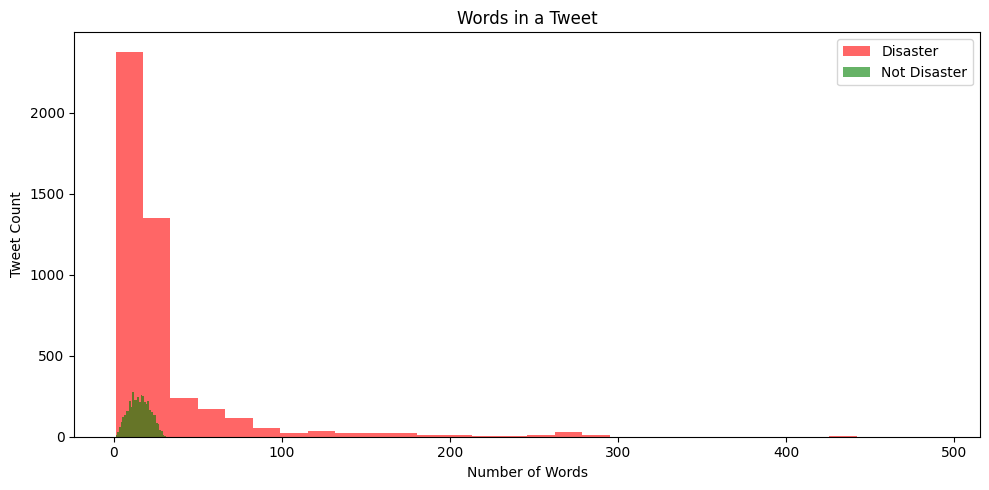

In [ ]:
# 各自詞數（用 str.split() 後取長度）
text_en = train_merged_data["text"].astype(str).fillna("")

disaster_words = text_en[train_merged_data["target"] == 1].str.split().map(len)
not_disaster_words = text_en[train_merged_data["target"] == 0].str.split().map(len)

# 畫圖
plt.figure(figsize=(10, 5))
plt.hist(disaster_words, bins=30, alpha=0.6, color='red', label='Disaster')
plt.hist(not_disaster_words, bins=30, alpha=0.6, color='green', label='Not Disaster')
plt.title('Words in a Tweet')
plt.xlabel('Number of Words')
plt.ylabel('Tweet Count')
plt.legend()
plt.tight_layout()
plt.show()


##前處理

In [ ]:
import string
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_20(text):
  space = re.compile(r'%20')
  return space.sub(r' ', text)

def remove_atsymbol(text):
    name = re.compile(r'@\S+')
    return name.sub(r' atsymbol ', text)


def remove_hashtag(text):
    hashtag = re.compile(r'#')
    return hashtag.sub(r' hashtag ', text)


def remove_exclamation(text):
    exclamation = re.compile(r'!')
    return exclamation.sub(r' exclamation ', text)


def remove_question(text):
    question = re.compile(r'?')
    return question.sub(r' question ', text)


def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))


def remove_number(text):
    number = re.compile(r'\d+')
    return number.sub(r' number ', text)


def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\x89û"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)




In [ ]:
#參考https://www.kaggle.com/code/masatoshikato/effective-eda-bert-in-nlp-bert-baseline，清除讓資料剩下純文字
train_data['text'] = train_data['text'].apply(lambda text: remove_html(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_atsymbol(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_hashtag(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_exclamation(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_punc(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_number(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_emoji(text))
train_data['text'] = train_data['text'].apply(lambda text: remove_20(text))



test_data['text']  = test_data['text'].apply(lambda text: remove_html(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_atsymbol(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_hashtag(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_exclamation(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_punc(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_number(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_emoji(text))
test_data['text']  = test_data['text'].apply(lambda text: remove_20(text))

#參考https://www.kaggle.com/code/divyadevadas/nlp-tweet-bert-roberta-eda-tensorflow-pytorch
train_data['text'] = train_data['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))

In [ ]:
#參考https://www.kaggle.com/code/tuckerarrants/bert-with-huggingface-transformers

contractions = {
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)



In [ ]:
test_data['text'] = test_data['text'].apply(lambda x: expand_contractions(x).lower())
train_data['text'] = train_data['text'].apply(lambda x: expand_contractions(x).lower())

In [ ]:
train_data["keyword"] = train_data["keyword"].fillna("")
test_data["keyword"] = test_data["keyword"].fillna("")
train_data["text_key"] = train_data["keyword"] + " " + train_data["text"]
test_data["text_key"] = test_data["keyword"] + " " + test_data["text"]

###加入ptt資料的前處理

In [ ]:


train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_html(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_atsymbol(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_hashtag(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_exclamation(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_punc(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_number(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_emoji(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda text: remove_20(text))
train_merged_data['text'] = train_merged_data['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
test_data['text'] = test_data['text'].apply(lambda x: expand_contractions(x).lower())
train_merged_data['text'] = train_merged_data['text'].apply(lambda x: expand_contractions(x).lower())

##training and testing

In [ ]:
models = [
    ("bert", "bert-base-uncased"),
    ("roberta", "roberta-base"),
    ("roberta_large", "roberta-large"),
    ("deberta", "microsoft/deberta-v3-base"),
    #("deberta_large", "microsoft/deberta-v3-large"),
    ("distilbert", "distilbert-base-uncased")
]

In [ ]:
model_f1_scores = []
ensemble_probs = []

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import optuna
from tqdm import tqdm


In [ ]:


def hp_space_progress(trial):
    trial_number = trial.number + 1
    total = 5
    print(f" Hyperparameter Trial {trial_number}/{total}")
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),#在整數範圍 [2, 4] 中選一個
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.5)
    }


In [ ]:
import torch

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])


In [ ]:
model_best_hyperparams = {}
study_histories = {}
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for log_name, model_path in models:
    print(f"\n開始模型：{log_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    train_df, val_df = train_test_split(train_merged_data, test_size=0.2, random_state=42)

    train_enc = tokenizer(train_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    train_enc["labels"] = train_df["target"].tolist()
    val_enc = tokenizer(val_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    val_enc["labels"] = val_df["target"].tolist()

    train_dataset = SimpleDataset(train_enc)
    val_dataset = SimpleDataset(val_enc)

    def objective(trial):
        params = hp_space_progress(trial)

        training_args = TrainingArguments(
            output_dir=f"./results_{log_name}_trial",
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="no",
            report_to="none",
            disable_tqdm=True,
            seed=42,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            fp16=True,
            **params
        )

        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer
        )

        trainer.train()
        metrics = trainer.evaluate()
        del trainer
        del model
        torch.cuda.empty_cache()
        return metrics["eval_f1"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)

    best_trial = study.best_trial

    model_best_hyperparams[log_name] = {
        "f1": best_trial.value,
        **best_trial.params
    }

    study_histories[log_name] = [
        (t.number, t.value, t.params) for t in study.trials
    ]

    print(f" {log_name} 最佳 F1: {best_trial.value:.4f}")
    print(f" 最佳參數: {best_trial.params}")


with open("best_hyperparams_keyword.json", "w") as f:
    json.dump(model_best_hyperparams, f, indent=2, ensure_ascii=False)

with open("optuna_history_keyword.json", "w") as f:
    json.dump(study_histories, f, indent=2, ensure_ascii=False)




開始模型：bert


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
[I 2025-05-14 05:17:41,270] A new study created in memory with name: no-name-0ba94750-5321-4dba-a1a6-b59e100bbd64


 Hyperparameter Trial 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-40-05f862b7c022>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[W 2025-05-14 05:17:45,906] Trial 0 failed with parameters: {'learning_rate': 1.980812424057643e-05, 'num_train_epochs': 2, 'weight_decay': 0.008242400562154029} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-40-05f862b7c022>", line 48, in objective
    trainer.train()
  File "/usr/l

KeyboardInterrupt: 

In [ ]:
with open("best_hyperparams_ptt.json", "w") as f:
    json.dump(model_best_hyperparams, f, indent=2, ensure_ascii=False)

with open("optuna_history_ptt.json", "w") as f:
    json.dump(study_histories, f, indent=2, ensure_ascii=False)

In [ ]:
import matplotlib.pyplot as plt
import json

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)
from optuna.trial import create_trial
from optuna.distributions import FloatDistribution, IntDistribution

def get_distribution(k, v):
    if "learning_rate" in k:
        return FloatDistribution(1e-5, 5e-5, log=True)
    elif "num_train_epochs" in k:
        return IntDistribution(2, 12)
    elif "weight_decay" in k:
        low = min(0.0, v * 0.9)
        high = max(0.3, v * 1.1)
        return FloatDistribution(low, high)
    else:
        return FloatDistribution(0.0, max(1.0, v * 1.2))
for model_name, trial_list in study_histories.items():
    print(f"模型：{model_name}")
    study = optuna.create_study(direction="maximize")
    for _, value, params in trial_list:
        trial = create_trial(
            value=value,
            params=params,
            distributions={k: get_distribution(k, params[k]) for k in params}
        )
        study.add_trial(trial)

    fig1 = plot_optimization_history(study)
    fig2 = plot_param_importances(study)
    fig1.show()
    fig2.show()
    if len(study.trials[0].params) >= 2:
        param_keys = list(study.trials[0].params.keys())
        fig3 = plot_contour(study, params=param_keys[:2])
        fig3.show()


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model_best_hyperparams

{'bert': {'f1': 0.8263795423956931,
  'learning_rate': 1.6344145642061143e-05,
  'num_train_epochs': 2,
  'weight_decay': 0.08106437493408808},
 'roberta': {'f1': 0.8338892595063375,
  'learning_rate': 1.5734631160550807e-05,
  'num_train_epochs': 3,
  'weight_decay': 0.25458241530932313},
 'roberta_large': {'f1': 0.8453038674033149,
  'learning_rate': 1.2786589888613404e-05,
  'num_train_epochs': 4,
  'weight_decay': 0.11290536468544204},
 'deberta': {'f1': 0.8412371134020619,
  'learning_rate': 1.259878713238685e-05,
  'num_train_epochs': 2,
  'weight_decay': 0.07325343287617858}}

In [ ]:
with open("best_hyperparams_ptt.json") as f:
    model_best_hyperparams = json.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensemble_probs = []
model_f1_scores = []

for log_name, model_path in models:
    print(f"\n 開始模型：{log_name}")
    best_params = model_best_hyperparams[log_name]

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    train_df, val_df = train_test_split(train_merged_data, test_size=0.3, random_state=42)

    train_enc = tokenizer(train_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    train_enc["labels"] = train_df["target"].tolist()
    val_enc = tokenizer(val_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    val_enc["labels"] = val_df["target"].tolist()
    test_enc = tokenizer(test_data["text"].tolist(), truncation=True, padding=True, max_length=256)

    train_dataset = SimpleDataset(train_enc)
    val_dataset = SimpleDataset(val_enc)
    test_dataset = SimpleDataset(test_enc)
    test_dataloader = DataLoader(test_dataset, batch_size=64)
    best_params = {k: v for k, v in model_best_hyperparams[log_name].items() if k != "f1"}

    train_args = TrainingArguments(
        output_dir=f'./results_{log_name}_best',
        logging_dir=f'./logs/{log_name}',
        run_name=log_name,
        eval_strategy='steps',
        eval_steps=200,
        save_strategy='epoch',
        logging_steps=10,
        report_to='tensorboard',
        save_total_limit=1,
        disable_tqdm=False,
        seed=42,
        **best_params
    )

    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)
    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    trainer.train()

    model.eval()
    test_probs = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"{log_name} Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]
            test_probs.extend(probs.cpu().numpy())

    test_probs = np.array(test_probs)
    ensemble_probs.append(test_probs)

    test_preds = (test_probs > 0.5).astype(int)
    submission = pd.DataFrame({"id": test_data["id"], "target": test_preds})
    submission.to_csv(f"submission_{log_name}_ptt_para.csv", index=False)
    print(f" 儲存完成：submission_{log_name}_ptt_para.csv")
    gc.collect()
    torch.cuda.empty_cache()

    if "target" in test_data.columns:
        f1 = f1_score(test_data["target"], test_preds)
        model_f1_scores.append((log_name, f1))
        print(f" 測試集 F1 score: {f1:.4f}")


 開始模型：bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-f80b41a79916>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.382700,0.387254,0.834462,0.833460,0.841100,0.825956
400,0.414500,0.376742,0.844996,0.839938,0.871072,0.810953
600,0.464300,0.369478,0.829571,0.835691,0.808989,0.864216
800,0.249600,0.415671,0.845749,0.846096,0.846732,0.845461
1000,0.410400,0.459700,0.852521,0.852187,0.856710,0.847712
1200,0.228700,0.423822,0.853649,0.853484,0.857035,0.849962
1400,0.243600,0.432032,0.855154,0.852885,0.869159,0.837209


bert Predicting: 100%|██████████| 51/51 [00:03<00:00, 15.11it/s]


 儲存完成：submission_bert_ptt_para.csv

 開始模型：roberta


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-f80b41a79916>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.450800,0.376693,0.843868,0.835774,0.884422,0.792198
400,0.452000,0.382148,0.842363,0.832467,0.891267,0.780945
600,0.483600,0.387040,0.842363,0.844064,0.837518,0.850713
800,0.348600,0.472488,0.851392,0.851671,0.852632,0.850713
1000,0.520600,0.662607,0.825809,0.834228,0.797945,0.873968
1200,0.390200,0.424452,0.858916,0.858651,0.862879,0.854464
1400,0.256100,0.437761,0.862302,0.852300,0.922271,0.792198
1600,0.393600,0.503694,0.851392,0.853323,0.844853,0.861965
1800,0.244000,0.495784,0.865688,0.862534,0.886076,0.840210
2000,0.383900,0.497778,0.866441,0.864348,0.880841,0.848462


roberta Predicting: 100%|██████████| 51/51 [00:03<00:00, 14.26it/s]


 儲存完成：submission_roberta_ptt_para.csv

 開始模型：roberta_large


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-f80b41a79916>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.489800,0.383351,0.839353,0.828858,0.889845,0.775694
400,0.596400,0.540195,0.823552,0.831960,0.796296,0.870968
600,0.556600,0.402072,0.824680,0.804530,0.912464,0.719430
800,0.380800,0.497506,0.855154,0.854332,0.861832,0.846962
1000,0.463700,0.480160,0.852144,0.850854,0.860983,0.840960
1200,0.399100,0.446661,0.846877,0.848643,0.841445,0.855964
1400,0.301600,0.456135,0.857788,0.843023,0.944186,0.761440
1600,0.403000,0.477119,0.862302,0.861991,0.866566,0.857464
1800,0.300300,0.521154,0.851768,0.854398,0.841952,0.867217
2000,0.371000,0.482852,0.864184,0.856233,0.912564,0.806452


roberta_large Predicting: 100%|██████████| 51/51 [00:10<00:00,  4.75it/s]


 儲存完成：submission_roberta_large_ptt_para.csv

 開始模型：deberta


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-f80b41a79916>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.511300,0.405002,0.837848,0.833010,0.861378,0.806452
400,0.449800,0.381825,0.843491,0.842305,0.851341,0.833458
600,0.397300,0.356335,0.852521,0.843575,0.901108,0.792948
800,0.334800,0.410506,0.861174,0.853630,0.905724,0.807202
1000,0.334200,0.448076,0.853649,0.854143,0.853823,0.854464
1200,0.352100,0.389669,0.851392,0.852557,0.848440,0.856714
1400,0.326100,0.422737,0.854778,0.854230,0.860076,0.848462


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

deberta Predicting: 100%|██████████| 51/51 [00:04<00:00, 11.65it/s]


 儲存完成：submission_deberta_ptt_para.csv

 開始模型：distilbert


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-f80b41a79916>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.414700,0.396661,0.833710,0.832322,0.841903,0.822956
400,0.525900,0.404374,0.832581,0.817847,0.900000,0.749437
600,0.468200,0.380432,0.835967,0.836582,0.835955,0.837209
800,0.288100,0.393852,0.849135,0.839536,0.899657,0.786947
1000,0.391000,0.411813,0.843491,0.843373,0.846561,0.840210
1200,0.375000,0.388926,0.843491,0.842424,0.850803,0.834209
1400,0.257600,0.418964,0.850640,0.843269,0.890000,0.801200
1600,0.399400,0.450129,0.847254,0.845274,0.859024,0.831958
1800,0.274900,0.497486,0.840858,0.841157,0.842105,0.840210
2000,0.359600,0.475586,0.848006,0.846154,0.859242,0.833458


distilbert Predicting: 100%|██████████| 51/51 [00:01<00:00, 30.71it/s]


 儲存完成：submission_distilbert_ptt_para.csv


In [ ]:
if ensemble_probs:
    avg_probs = np.mean(ensemble_probs, axis=0)
    final_preds = (avg_probs > 0.5).astype(int)
    ensemble_submission = pd.DataFrame({"id": test_data["id"], "target": final_preds})
    ensemble_submission.to_csv("submission_ensemble_para_ptt.csv", index=False)
    print("已輸出加權平均 ensemble 結果：submission_ensemble_para_ptt.csv")

已輸出加權平均 ensemble 結果：submission_ensemble_para_ptt.csv


In [ ]:
ensemble_probs

[array([0.99866724, 0.9997316 , 0.9997478 , ..., 0.99963665, 0.9931096 ,
        0.9994429 ], dtype=float32),
 array([0.99664307, 0.99974483, 0.9997459 , ..., 0.99974483, 0.998835  ,
        0.99899954], dtype=float32),
 array([0.9991186 , 0.99987364, 0.99979264, ..., 0.9998306 , 0.99649614,
        0.99909425], dtype=float32),
 array([0.98638946, 0.9849274 , 0.99209267, ..., 0.9912378 , 0.9828068 ,
        0.9789353 ], dtype=float32),
 array([0.9859904 , 0.9898107 , 0.99031025, ..., 0.9904959 , 0.98899186,
        0.98840266], dtype=float32),
 array([0.99791294, 0.9992237 , 0.9990638 , ..., 0.9992372 , 0.9962419 ,
        0.9987576 ], dtype=float32)]

In [ ]:
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}
fig = plot_param_importances(study)
fig.show(config=plotly_config)

In [ ]:
import optuna
from optuna.visualization import plot_contour
from optuna.trial import FrozenTrial
from optuna.samplers import RandomSampler
import json
import plotly.io as pio
import datetime

# 讀取歷史試驗資料
with open("optuna_history_keyword.json") as f:
    history = json.load(f)

# 定義各參數的分布
def get_distribution(k):
    if k == "learning_rate":
        return optuna.distributions.FloatDistribution(1e-5, 5e-5, log=True)
    elif k == "num_train_epochs":
        return optuna.distributions.IntDistribution(3, 12)
    elif k == "weight_decay":
        return optuna.distributions.FloatDistribution(0.0, 0.3)
    elif k == "per_device_train_batch_size":
        return optuna.distributions.CategoricalDistribution([8, 16, 32])
    else:
        return optuna.distributions.UniformDistribution(0.0, 1.0)

# 對每個模型畫 lr vs epoch 的 f1 圖
for model_name, model_trials in history.items():
    now = datetime.datetime.now()
    trials = []
    for trial_id, f1, params in model_trials:
        if "learning_rate" not in params or "num_train_epochs" not in params:
            continue

        trial = FrozenTrial(
            number=trial_id,
            value=f1,
            state=optuna.trial.TrialState.COMPLETE,
            params=params,
            distributions={k: get_distribution(k) for k in params},
            user_attrs={},
            system_attrs={},
            intermediate_values={},
            datetime_start=now,
            datetime_complete=now,
            trial_id=trial_id
        )
        trials.append(trial)

    if len(trials) < 2:
        print(f" {model_name} 不足以繪圖（有效 trial 太少）")
        continue

    study = optuna.create_study(direction="maximize", sampler=RandomSampler())
    study.add_trials(trials)

    fig = plot_contour(study, params=["learning_rate", "num_train_epochs"])
    fig.update_layout(
        title=f"{model_name}: learning_rate vs num_train_epochs",
        xaxis_title="learning_rate",
        yaxis_title="num_train_epochs",
    )
    fig.update_layout(xaxis={"tickformat": ".1e"})
    pio.show(fig)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

##切割完train 和 val再加入ptt資料進train

In [ ]:
train_data = pd.read_csv("train.csv")
train_ptt_data = pd.read_csv("disater_ptt_v2.csv")
train_ptt_sample = train_ptt_data.sample(n=500, random_state=42).reset_index(drop=True)
test_data = pd.read_csv("test.csv")

In [ ]:
train_ptt_sample = train_ptt_sample.rename(columns={'text_en': 'text'})
train_ptt_sample['target'] = 1

In [ ]:
train_ptt_sample

,text,target
0,The traffic accident on the south side of the ...,1
1,Today (9/21) COVID-19 is a state of emergency....,1
2,The earthquake. How's everybody feeling this t...,1
3,-Sent from JPTT on my Xiaomi Redmi Note 7.,1
4,Re: Reading in May was cancelled because of th...,1
...,...,...
495,The earthquake... shakes it up so hard... it's...,1
496,Looking for a car crash recorder at 10/3 p.m. ...,1
497,"When we just got home from work, we saw at lea...",1
498,Is it a sign of an earthquake? There are earth...,1


In [ ]:
def preprocess_text(df):
    df['text'] = df['text'].apply(lambda x: remove_html(x))
    df['text'] = df['text'].apply(lambda x: remove_atsymbol(x))
    df['text'] = df['text'].apply(lambda x: remove_hashtag(x))
    df['text'] = df['text'].apply(lambda x: remove_exclamation(x))
    df['text'] = df['text'].apply(lambda x: remove_punc(x))
    df['text'] = df['text'].apply(lambda x: remove_number(x))
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    df['text'] = df['text'].apply(lambda x: remove_20(x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
    return df
train_data = preprocess_text(train_data)
train_ptt_sample = preprocess_text(train_ptt_sample)
test_data = preprocess_text(test_data)

In [ ]:
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['target'])
train_df = pd.concat([train_df, train_ptt_sample], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
model_best_hyperparams = {}
study_histories = {}
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for log_name, model_path in models:
    print(f"\n開始模型：{log_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    train_enc = tokenizer(train_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    train_enc["labels"] = train_df["target"].tolist()
    val_enc = tokenizer(val_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    val_enc["labels"] = val_df["target"].tolist()

    train_dataset = SimpleDataset(train_enc)
    val_dataset = SimpleDataset(val_enc)

    def objective(trial):
        params = hp_space_progress(trial)

        training_args = TrainingArguments(
            output_dir=f"./results_{log_name}_trial",
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="no",
            report_to="none",
            disable_tqdm=True,
            seed=42,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            fp16=True,
            **params
        )

        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer
        )

        trainer.train()
        metrics = trainer.evaluate()
        del trainer
        del model
        torch.cuda.empty_cache()
        return metrics["eval_f1"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)

    best_trial = study.best_trial

    model_best_hyperparams[log_name] = {
        "f1": best_trial.value,
        **best_trial.params
    }

    study_histories[log_name] = [
        (t.number, t.value, t.params) for t in study.trials
    ]

    print(f" {log_name} 最佳 F1: {best_trial.value:.4f}")
    print(f" 最佳參數: {best_trial.params}")


with open("best_hyperparams_ptt_in_train.json", "w") as f:
    json.dump(model_best_hyperparams, f, indent=2, ensure_ascii=False)

with open("optuna_ptt_in_train.json", "w") as f:
    json.dump(study_histories, f, indent=2, ensure_ascii=False)




開始模型：bert


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
[I 2025-05-14 03:33:54,085] A new study created in memory with name: no-name-aa533acc-fe80-49ae-bfdf-51eb517cef72


 Hyperparameter Trial 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.37425196170806885, 'eval_accuracy': 0.8476690741956664, 'eval_f1': 0.8135048231511254, 'eval_precision': 0.8576271186440678, 'eval_recall': 0.7737003058103975, 'eval_runtime': 1.6623, 'eval_samples_per_second': 916.211, 'eval_steps_per_second': 57.752, 'epoch': 1.0}
{'eval_loss': 0.39424094557762146, 'eval_accuracy': 0.8470124753775443, 'eval_f1': 0.8172549019607843, 'eval_precision': 0.8389694041867954, 'eval_recall': 0.7966360856269113, 'eval_runtime': 1.6659, 'eval_samples_per_second': 914.206, 'eval_steps_per_second': 57.626, 'epoch': 2.0}
{'eval_loss': 0.5171639919281006, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.7981438515081206, 'eval_precision': 0.8075117370892019, 'eval_recall': 0.7889908256880734, 'eval_runtime': 1.6618, 'eval_samples_per_second': 916.498, 'eval_steps_per_second': 57.77, 'epoch': 3.0}
{'train_runtime': 270.4451, 'train_samples_per_second': 73.102, 'train_steps_per_second': 4.57, 'train_loss': 0.32894354267799353, 'epoch': 3.0}


[I 2025-05-14 03:38:27,418] Trial 0 finished with value: 0.7981438515081206 and parameters: {'learning_rate': 2.2029024097352503e-05, 'num_train_epochs': 3, 'weight_decay': 0.2132186509727309}. Best is trial 0 with value: 0.7981438515081206.


{'eval_loss': 0.5171639919281006, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.7981438515081206, 'eval_precision': 0.8075117370892019, 'eval_recall': 0.7889908256880734, 'eval_runtime': 1.6346, 'eval_samples_per_second': 931.71, 'eval_steps_per_second': 58.729, 'epoch': 3.0}
 Hyperparameter Trial 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.3739423155784607, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8033613445378152, 'eval_precision': 0.8917910447761194, 'eval_recall': 0.7308868501529052, 'eval_runtime': 1.6879, 'eval_samples_per_second': 902.318, 'eval_steps_per_second': 56.876, 'epoch': 1.0}
{'eval_loss': 0.39481574296951294, 'eval_accuracy': 0.8417596848325674, 'eval_f1': 0.8079681274900399, 'eval_precision': 0.8435940099833611, 'eval_recall': 0.7752293577981652, 'eval_runtime': 1.6942, 'eval_samples_per_second': 898.964, 'eval_steps_per_second': 56.665, 'epoch': 2.0}
{'train_runtime': 180.497, 'train_samples_per_second': 73.021, 'train_steps_per_second': 4.565, 'train_loss': 0.38155187217934616, 'epoch': 2.0}


[I 2025-05-14 03:41:30,566] Trial 1 finished with value: 0.8079681274900399 and parameters: {'learning_rate': 1.5824576999472283e-05, 'num_train_epochs': 2, 'weight_decay': 0.26006390288622655}. Best is trial 1 with value: 0.8079681274900399.


{'eval_loss': 0.39481574296951294, 'eval_accuracy': 0.8417596848325674, 'eval_f1': 0.8079681274900399, 'eval_precision': 0.8435940099833611, 'eval_recall': 0.7752293577981652, 'eval_runtime': 1.6556, 'eval_samples_per_second': 919.887, 'eval_steps_per_second': 57.984, 'epoch': 2.0}
 Hyperparameter Trial 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.3864932954311371, 'eval_accuracy': 0.8456992777413, 'eval_f1': 0.8124501197126895, 'eval_precision': 0.8497495826377296, 'eval_recall': 0.7782874617737003, 'eval_runtime': 1.6861, 'eval_samples_per_second': 903.256, 'eval_steps_per_second': 56.935, 'epoch': 1.0}
{'eval_loss': 0.4023149013519287, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8097560975609757, 'eval_precision': 0.8645833333333334, 'eval_recall': 0.7614678899082569, 'eval_runtime': 1.6852, 'eval_samples_per_second': 903.76, 'eval_steps_per_second': 56.967, 'epoch': 2.0}
{'eval_loss': 0.6125798225402832, 'eval_accuracy': 0.8266579120157583, 'eval_f1': 0.7996965098634294, 'eval_precision': 0.7936746987951807, 'eval_recall': 0.8058103975535168, 'eval_runtime': 1.6764, 'eval_samples_per_second': 908.477, 'eval_steps_per_second': 57.264, 'epoch': 3.0}
{'train_runtime': 270.9843, 'train_samples_per_second': 72.956, 'train_steps_per_second': 4.561, 'train_loss': 0.3059183015792501, 'epoch': 3.0}


[I 2025-05-14 03:46:04,200] Trial 2 finished with value: 0.7996965098634294 and parameters: {'learning_rate': 4.823663304900422e-05, 'num_train_epochs': 3, 'weight_decay': 0.22273579617499745}. Best is trial 1 with value: 0.8079681274900399.


{'eval_loss': 0.6125798225402832, 'eval_accuracy': 0.8266579120157583, 'eval_f1': 0.7996965098634294, 'eval_precision': 0.7936746987951807, 'eval_recall': 0.8058103975535168, 'eval_runtime': 1.6502, 'eval_samples_per_second': 922.922, 'eval_steps_per_second': 58.175, 'epoch': 3.0}
 Hyperparameter Trial 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.37781089544296265, 'eval_accuracy': 0.8456992777413, 'eval_f1': 0.801352493660186, 'eval_precision': 0.8960302457466919, 'eval_recall': 0.7247706422018348, 'eval_runtime': 1.6944, 'eval_samples_per_second': 898.821, 'eval_steps_per_second': 56.656, 'epoch': 1.0}
{'eval_loss': 0.38538238406181335, 'eval_accuracy': 0.8404464871963231, 'eval_f1': 0.800982800982801, 'eval_precision': 0.8624338624338624, 'eval_recall': 0.7477064220183486, 'eval_runtime': 1.687, 'eval_samples_per_second': 902.812, 'eval_steps_per_second': 56.907, 'epoch': 2.0}
{'eval_loss': 0.45597246289253235, 'eval_accuracy': 0.8292843072882469, 'eval_f1': 0.8024316109422492, 'eval_precision': 0.797583081570997, 'eval_recall': 0.8073394495412844, 'eval_runtime': 1.6926, 'eval_samples_per_second': 899.818, 'eval_steps_per_second': 56.719, 'epoch': 3.0}
{'eval_loss': 0.5086159110069275, 'eval_accuracy': 0.8253447143795141, 'eval_f1': 0.7981790591805766, 'eval_precision': 0.7921686746987951, 'eval_recall': 0.8

[I 2025-05-14 03:52:08,643] Trial 3 finished with value: 0.7981790591805766 and parameters: {'learning_rate': 1.0323146890071335e-05, 'num_train_epochs': 4, 'weight_decay': 0.48228399443878195}. Best is trial 1 with value: 0.8079681274900399.


{'eval_loss': 0.5086159110069275, 'eval_accuracy': 0.8253447143795141, 'eval_f1': 0.7981790591805766, 'eval_precision': 0.7921686746987951, 'eval_recall': 0.8042813455657493, 'eval_runtime': 1.6511, 'eval_samples_per_second': 922.397, 'eval_steps_per_second': 58.142, 'epoch': 4.0}
 Hyperparameter Trial 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.39518600702285767, 'eval_accuracy': 0.8365068942875903, 'eval_f1': 0.8028503562945368, 'eval_precision': 0.8325123152709359, 'eval_recall': 0.7752293577981652, 'eval_runtime': 1.6684, 'eval_samples_per_second': 912.866, 'eval_steps_per_second': 57.541, 'epoch': 1.0}
{'eval_loss': 0.4187999963760376, 'eval_accuracy': 0.8365068942875903, 'eval_f1': 0.80253766851705, 'eval_precision': 0.8336079077429983, 'eval_recall': 0.7737003058103975, 'eval_runtime': 1.6752, 'eval_samples_per_second': 909.125, 'eval_steps_per_second': 57.305, 'epoch': 2.0}
{'eval_loss': 0.6112962365150452, 'eval_accuracy': 0.8292843072882469, 'eval_f1': 0.802130898021309, 'eval_precision': 0.7984848484848485, 'eval_recall': 0.8058103975535168, 'eval_runtime': 1.6793, 'eval_samples_per_second': 906.953, 'eval_steps_per_second': 57.168, 'epoch': 3.0}
{'train_runtime': 270.9792, 'train_samples_per_second': 72.958, 'train_steps_per_second': 4.561, 'train_loss': 0.3003048449272477, 'epoch': 3.0}


[I 2025-05-14 03:56:42,299] Trial 4 finished with value: 0.802130898021309 and parameters: {'learning_rate': 4.9765207950109025e-05, 'num_train_epochs': 3, 'weight_decay': 0.30971151783917145}. Best is trial 1 with value: 0.8079681274900399.


{'eval_loss': 0.6112962365150452, 'eval_accuracy': 0.8292843072882469, 'eval_f1': 0.802130898021309, 'eval_precision': 0.7984848484848485, 'eval_recall': 0.8058103975535168, 'eval_runtime': 1.6392, 'eval_samples_per_second': 929.129, 'eval_steps_per_second': 58.566, 'epoch': 3.0}
 bert 最佳 F1: 0.8080
 最佳參數: {'learning_rate': 1.5824576999472283e-05, 'num_train_epochs': 2, 'weight_decay': 0.26006390288622655}

開始模型：roberta


[I 2025-05-14 03:56:43,165] A new study created in memory with name: no-name-e452dbba-9694-437a-b691-f537e332a2c0


 Hyperparameter Trial 1/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.3753512501716614, 'eval_accuracy': 0.8404464871963231, 'eval_f1': 0.796652719665272, 'eval_precision': 0.8798521256931608, 'eval_recall': 0.72782874617737, 'eval_runtime': 1.7929, 'eval_samples_per_second': 849.459, 'eval_steps_per_second': 53.544, 'epoch': 1.0}
{'eval_loss': 0.40258368849754333, 'eval_accuracy': 0.8378200919238346, 'eval_f1': 0.8062745098039216, 'eval_precision': 0.8276972624798712, 'eval_recall': 0.7859327217125383, 'eval_runtime': 1.7882, 'eval_samples_per_second': 851.709, 'eval_steps_per_second': 53.686, 'epoch': 2.0}
{'train_runtime': 185.5476, 'train_samples_per_second': 71.033, 'train_steps_per_second': 4.441, 'train_loss': 0.39060063038057496, 'epoch': 2.0}


[I 2025-05-14 03:59:51,482] Trial 0 finished with value: 0.8062745098039216 and parameters: {'learning_rate': 1.186234072172106e-05, 'num_train_epochs': 2, 'weight_decay': 0.29162665260528725}. Best is trial 0 with value: 0.8062745098039216.


{'eval_loss': 0.40258368849754333, 'eval_accuracy': 0.8378200919238346, 'eval_f1': 0.8062745098039216, 'eval_precision': 0.8276972624798712, 'eval_recall': 0.7859327217125383, 'eval_runtime': 1.7469, 'eval_samples_per_second': 871.848, 'eval_steps_per_second': 54.956, 'epoch': 2.0}
 Hyperparameter Trial 2/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.37101051211357117, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8026981450252951, 'eval_precision': 0.8947368421052632, 'eval_recall': 0.72782874617737, 'eval_runtime': 1.7831, 'eval_samples_per_second': 854.153, 'eval_steps_per_second': 53.84, 'epoch': 1.0}
{'eval_loss': 0.39812153577804565, 'eval_accuracy': 0.8391332895600788, 'eval_f1': 0.8060174188440221, 'eval_precision': 0.8357963875205254, 'eval_recall': 0.7782874617737003, 'eval_runtime': 1.7752, 'eval_samples_per_second': 857.943, 'eval_steps_per_second': 54.079, 'epoch': 2.0}
{'train_runtime': 185.5672, 'train_samples_per_second': 71.025, 'train_steps_per_second': 4.44, 'train_loss': 0.3895523293504437, 'epoch': 2.0}


[I 2025-05-14 04:02:59,795] Trial 1 finished with value: 0.8060174188440221 and parameters: {'learning_rate': 2.249110197714865e-05, 'num_train_epochs': 2, 'weight_decay': 0.21026915785280792}. Best is trial 0 with value: 0.8062745098039216.


{'eval_loss': 0.39812153577804565, 'eval_accuracy': 0.8391332895600788, 'eval_f1': 0.8060174188440221, 'eval_precision': 0.8357963875205254, 'eval_recall': 0.7782874617737003, 'eval_runtime': 1.7595, 'eval_samples_per_second': 865.571, 'eval_steps_per_second': 54.56, 'epoch': 2.0}
 Hyperparameter Trial 3/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.37716495990753174, 'eval_accuracy': 0.8496388706500329, 'eval_f1': 0.8142741281427412, 'eval_precision': 0.8670120898100173, 'eval_recall': 0.7675840978593272, 'eval_runtime': 1.7972, 'eval_samples_per_second': 847.453, 'eval_steps_per_second': 53.418, 'epoch': 1.0}
{'eval_loss': 0.3942175507545471, 'eval_accuracy': 0.845042678923178, 'eval_f1': 0.8056013179571664, 'eval_precision': 0.8732142857142857, 'eval_recall': 0.7477064220183486, 'eval_runtime': 1.7923, 'eval_samples_per_second': 849.729, 'eval_steps_per_second': 53.561, 'epoch': 2.0}
{'eval_loss': 0.45469725131988525, 'eval_accuracy': 0.8305975049244911, 'eval_f1': 0.8033536585365854, 'eval_precision': 0.8009118541033434, 'eval_recall': 0.8058103975535168, 'eval_runtime': 1.7637, 'eval_samples_per_second': 863.505, 'eval_steps_per_second': 54.43, 'epoch': 3.0}
{'eval_loss': 0.5516478419303894, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.8003060443764346, 'eval_precision': 0.8009188361408882, 'eval_recall':

[I 2025-05-14 04:09:12,920] Trial 2 finished with value: 0.8003060443764346 and parameters: {'learning_rate': 1.8375833105453737e-05, 'num_train_epochs': 4, 'weight_decay': 0.18339634673244753}. Best is trial 0 with value: 0.8062745098039216.


{'eval_loss': 0.5516478419303894, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.8003060443764346, 'eval_precision': 0.8009188361408882, 'eval_recall': 0.7996941896024465, 'eval_runtime': 1.7272, 'eval_samples_per_second': 881.756, 'eval_steps_per_second': 55.58, 'epoch': 4.0}
 Hyperparameter Trial 4/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.3848896920681, 'eval_accuracy': 0.855548260013132, 'eval_f1': 0.8160535117056856, 'eval_precision': 0.9003690036900369, 'eval_recall': 0.746177370030581, 'eval_runtime': 1.7961, 'eval_samples_per_second': 847.964, 'eval_steps_per_second': 53.45, 'epoch': 1.0}
{'eval_loss': 0.3755890727043152, 'eval_accuracy': 0.8489822718319107, 'eval_f1': 0.8089700996677741, 'eval_precision': 0.8854545454545455, 'eval_recall': 0.7446483180428135, 'eval_runtime': 1.8003, 'eval_samples_per_second': 845.953, 'eval_steps_per_second': 53.323, 'epoch': 2.0}
{'eval_loss': 0.47293907403945923, 'eval_accuracy': 0.835193696651346, 'eval_f1': 0.8070714834742506, 'eval_precision': 0.8114374034003091, 'eval_recall': 0.8027522935779816, 'eval_runtime': 1.8112, 'eval_samples_per_second': 840.902, 'eval_steps_per_second': 53.005, 'epoch': 3.0}
{'train_runtime': 278.667, 'train_samples_per_second': 70.945, 'train_steps_per_second': 4.435, 'train_loss': 0.3555357602807696, 'epoch': 3.0}


[I 2025-05-14 04:13:54,350] Trial 3 finished with value: 0.8070714834742506 and parameters: {'learning_rate': 2.714703061181818e-05, 'num_train_epochs': 3, 'weight_decay': 0.27084955423244184}. Best is trial 3 with value: 0.8070714834742506.


{'eval_loss': 0.47293907403945923, 'eval_accuracy': 0.835193696651346, 'eval_f1': 0.8070714834742506, 'eval_precision': 0.8114374034003091, 'eval_recall': 0.8027522935779816, 'eval_runtime': 1.7754, 'eval_samples_per_second': 857.811, 'eval_steps_per_second': 54.071, 'epoch': 3.0}
 Hyperparameter Trial 5/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.370580792427063, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.7972270363951474, 'eval_precision': 0.92, 'eval_recall': 0.7033639143730887, 'eval_runtime': 1.8069, 'eval_samples_per_second': 842.871, 'eval_steps_per_second': 53.129, 'epoch': 1.0}
{'eval_loss': 0.38950175046920776, 'eval_accuracy': 0.8502954694681549, 'eval_f1': 0.8080808080808081, 'eval_precision': 0.898876404494382, 'eval_recall': 0.7339449541284404, 'eval_runtime': 1.8024, 'eval_samples_per_second': 844.988, 'eval_steps_per_second': 53.263, 'epoch': 2.0}
{'eval_loss': 0.46253687143325806, 'eval_accuracy': 0.8417596848325674, 'eval_f1': 0.8156082631981637, 'eval_precision': 0.8162327718223583, 'eval_recall': 0.8149847094801224, 'eval_runtime': 1.7945, 'eval_samples_per_second': 848.705, 'eval_steps_per_second': 53.497, 'epoch': 3.0}
{'eval_loss': 0.5531506538391113, 'eval_accuracy': 0.8319107025607354, 'eval_f1': 0.802773497688752, 'eval_precision': 0.8090062111801242, 'eval_recall': 0.796636085626

[I 2025-05-14 04:20:09,272] Trial 4 finished with value: 0.802773497688752 and parameters: {'learning_rate': 1.7082116828287418e-05, 'num_train_epochs': 4, 'weight_decay': 0.13982259960610088}. Best is trial 3 with value: 0.8070714834742506.


{'eval_loss': 0.5531506538391113, 'eval_accuracy': 0.8319107025607354, 'eval_f1': 0.802773497688752, 'eval_precision': 0.8090062111801242, 'eval_recall': 0.7966360856269113, 'eval_runtime': 1.758, 'eval_samples_per_second': 866.341, 'eval_steps_per_second': 54.608, 'epoch': 4.0}
 roberta 最佳 F1: 0.8071
 最佳參數: {'learning_rate': 2.714703061181818e-05, 'num_train_epochs': 3, 'weight_decay': 0.27084955423244184}

開始模型：roberta_large


[I 2025-05-14 04:20:09,968] A new study created in memory with name: no-name-7330fe7f-2d6f-45a1-a58e-399a84293363


 Hyperparameter Trial 1/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.3680500090122223, 'eval_accuracy': 0.8483256730137886, 'eval_f1': 0.8050632911392405, 'eval_precision': 0.8983050847457628, 'eval_recall': 0.7293577981651376, 'eval_runtime': 4.9546, 'eval_samples_per_second': 307.389, 'eval_steps_per_second': 19.376, 'epoch': 1.0}
{'eval_loss': 0.3802533447742462, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8103727714748784, 'eval_precision': 0.8620689655172413, 'eval_recall': 0.764525993883792, 'eval_runtime': 4.9596, 'eval_samples_per_second': 307.083, 'eval_steps_per_second': 19.357, 'epoch': 2.0}
{'train_runtime': 568.5478, 'train_samples_per_second': 23.182, 'train_steps_per_second': 1.449, 'train_loss': 0.4057704962573005, 'epoch': 2.0}


[I 2025-05-14 04:29:44,934] Trial 0 finished with value: 0.8103727714748784 and parameters: {'learning_rate': 1.3857879194914418e-05, 'num_train_epochs': 2, 'weight_decay': 0.4895092450711962}. Best is trial 0 with value: 0.8103727714748784.


{'eval_loss': 0.3802533447742462, 'eval_accuracy': 0.8463558765594222, 'eval_f1': 0.8103727714748784, 'eval_precision': 0.8620689655172413, 'eval_recall': 0.764525993883792, 'eval_runtime': 4.8438, 'eval_samples_per_second': 314.422, 'eval_steps_per_second': 19.819, 'epoch': 2.0}
 Hyperparameter Trial 2/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.5044421553611755, 'eval_accuracy': 0.8299409061063691, 'eval_f1': 0.7916331456154465, 'eval_precision': 0.8353140916808149, 'eval_recall': 0.7522935779816514, 'eval_runtime': 4.9266, 'eval_samples_per_second': 309.141, 'eval_steps_per_second': 19.486, 'epoch': 1.0}
{'eval_loss': 0.43594297766685486, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.7993850883935434, 'eval_precision': 0.80370942812983, 'eval_recall': 0.7951070336391437, 'eval_runtime': 4.914, 'eval_samples_per_second': 309.932, 'eval_steps_per_second': 19.536, 'epoch': 2.0}
{'train_runtime': 567.2681, 'train_samples_per_second': 23.234, 'train_steps_per_second': 1.453, 'train_loss': 0.5239372623776927, 'epoch': 2.0}


[I 2025-05-14 04:39:18,604] Trial 1 finished with value: 0.7993850883935434 and parameters: {'learning_rate': 2.6629781243894096e-05, 'num_train_epochs': 2, 'weight_decay': 0.2150953342904373}. Best is trial 0 with value: 0.8103727714748784.


{'eval_loss': 0.43594297766685486, 'eval_accuracy': 0.8286277084701248, 'eval_f1': 0.7993850883935434, 'eval_precision': 0.80370942812983, 'eval_recall': 0.7951070336391437, 'eval_runtime': 4.8043, 'eval_samples_per_second': 317.009, 'eval_steps_per_second': 19.982, 'epoch': 2.0}
 Hyperparameter Trial 3/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.38558265566825867, 'eval_accuracy': 0.8424162836506894, 'eval_f1': 0.7989949748743719, 'eval_precision': 0.8833333333333333, 'eval_recall': 0.7293577981651376, 'eval_runtime': 4.9536, 'eval_samples_per_second': 307.453, 'eval_steps_per_second': 19.38, 'epoch': 1.0}
{'eval_loss': 0.3953862190246582, 'eval_accuracy': 0.8502954694681549, 'eval_f1': 0.8207547169811321, 'eval_precision': 0.8446601941747572, 'eval_recall': 0.7981651376146789, 'eval_runtime': 4.9392, 'eval_samples_per_second': 308.349, 'eval_steps_per_second': 19.436, 'epoch': 2.0}
{'train_runtime': 567.7998, 'train_samples_per_second': 23.212, 'train_steps_per_second': 1.451, 'train_loss': 0.40874499719119767, 'epoch': 2.0}


[I 2025-05-14 04:48:52,806] Trial 2 finished with value: 0.8207547169811321 and parameters: {'learning_rate': 1.5375730776274533e-05, 'num_train_epochs': 2, 'weight_decay': 0.4897383566867592}. Best is trial 2 with value: 0.8207547169811321.


{'eval_loss': 0.3953862190246582, 'eval_accuracy': 0.8502954694681549, 'eval_f1': 0.8207547169811321, 'eval_precision': 0.8446601941747572, 'eval_recall': 0.7981651376146789, 'eval_runtime': 4.8122, 'eval_samples_per_second': 316.487, 'eval_steps_per_second': 19.949, 'epoch': 2.0}
 Hyperparameter Trial 4/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.37229132652282715, 'eval_accuracy': 0.8522652659225214, 'eval_f1': 0.8129675810473815, 'eval_precision': 0.8907103825136612, 'eval_recall': 0.7477064220183486, 'eval_runtime': 4.9288, 'eval_samples_per_second': 308.999, 'eval_steps_per_second': 19.477, 'epoch': 1.0}
{'eval_loss': 0.390404611825943, 'eval_accuracy': 0.8489822718319107, 'eval_f1': 0.806070826306914, 'eval_precision': 0.8984962406015038, 'eval_recall': 0.7308868501529052, 'eval_runtime': 4.8994, 'eval_samples_per_second': 310.852, 'eval_steps_per_second': 19.594, 'epoch': 2.0}
{'eval_loss': 0.4278288781642914, 'eval_accuracy': 0.8489822718319107, 'eval_f1': 0.8205928237129485, 'eval_precision': 0.8375796178343949, 'eval_recall': 0.8042813455657493, 'eval_runtime': 4.9319, 'eval_samples_per_second': 308.806, 'eval_steps_per_second': 19.465, 'epoch': 3.0}
{'eval_loss': 0.5844855904579163, 'eval_accuracy': 0.8338804990151018, 'eval_f1': 0.8040278853601859, 'eval_precision': 0.814756671899529, 'eval_recall': 0

[I 2025-05-14 05:07:55,286] Trial 3 finished with value: 0.8040278853601859 and parameters: {'learning_rate': 1.261851007337209e-05, 'num_train_epochs': 4, 'weight_decay': 0.07799684251988731}. Best is trial 2 with value: 0.8207547169811321.


{'eval_loss': 0.5844855904579163, 'eval_accuracy': 0.8338804990151018, 'eval_f1': 0.8040278853601859, 'eval_precision': 0.814756671899529, 'eval_recall': 0.7935779816513762, 'eval_runtime': 4.8311, 'eval_samples_per_second': 315.252, 'eval_steps_per_second': 19.871, 'epoch': 4.0}
 Hyperparameter Trial 5/5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-ea68ba655289>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.369631826877594, 'eval_accuracy': 0.8535784635587655, 'eval_f1': 0.8111769686706182, 'eval_precision': 0.9089184060721063, 'eval_recall': 0.7324159021406728, 'eval_runtime': 4.9372, 'eval_samples_per_second': 308.475, 'eval_steps_per_second': 19.444, 'epoch': 1.0}


[W 2025-05-14 05:14:16,597] Trial 4 failed with parameters: {'learning_rate': 1.4543895879904991e-05, 'num_train_epochs': 2, 'weight_decay': 0.33712729346342346} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-28-ea68ba655289>", line 47, in objective
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2560, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3782, 

KeyboardInterrupt: 

In [ ]:
with open("best_hyperparams_ptt_in_train.json") as f:
    model_best_hyperparams = json.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensemble_probs = []
model_f1_scores = []

for log_name, model_path in models:
    print(f"\n 開始模型：{log_name}")
    best_params = model_best_hyperparams[log_name]

    tokenizer = AutoTokenizer.from_pretrained(model_path)


    train_enc = tokenizer(train_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    train_enc["labels"] = train_df["target"].tolist()
    val_enc = tokenizer(val_df["text"].tolist(), truncation=True, padding=True, max_length=256)
    val_enc["labels"] = val_df["target"].tolist()
    test_enc = tokenizer(test_data["text"].tolist(), truncation=True, padding=True, max_length=256)

    train_dataset = SimpleDataset(train_enc)
    val_dataset = SimpleDataset(val_enc)
    test_dataset = SimpleDataset(test_enc)
    test_dataloader = DataLoader(test_dataset, batch_size=64)
    best_params = {k: v for k, v in model_best_hyperparams[log_name].items() if k != "f1"}

    train_args = TrainingArguments(
        output_dir=f'./results_{log_name}_best',
        logging_dir=f'./logs/{log_name}',
        run_name=log_name,
        eval_strategy='steps',
        eval_steps=200,
        save_strategy='epoch',
        logging_steps=10,
        report_to='tensorboard',
        save_total_limit=1,
        disable_tqdm=False,
        seed=42,
        **best_params
    )

    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)
    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    trainer.train()

    model.eval()
    test_probs = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"{log_name} Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]
            test_probs.extend(probs.cpu().numpy())

    test_probs = np.array(test_probs)
    ensemble_probs.append(test_probs)

    test_preds = (test_probs > 0.5).astype(int)
    submission = pd.DataFrame({"id": test_data["id"], "target": test_preds})
    submission.to_csv(f"submission_{log_name}_ptt_in_train_para.csv", index=False)
    print(f" 儲存完成：submission_{log_name}_ptt_in_train_para.csv")
    gc.collect()
    torch.cuda.empty_cache()

    if "target" in test_data.columns:
        f1 = f1_score(test_data["target"], test_preds)
        model_f1_scores.append((log_name, f1))
        print(f" 測試集 F1 score: {f1:.4f}")

In [ ]:
if ensemble_probs:
    avg_probs = np.mean(ensemble_probs, axis=0)
    final_preds = (avg_probs > 0.5).astype(int)
    ensemble_submission = pd.DataFrame({"id": test_data["id"], "target": final_preds})
    ensemble_submission.to_csv("submission_ensemble_ptt_in_train_para.csv", index=False)
    print("已輸出加權平均 ensemble 結果：submission_ensemble_ptt_in_train_para.csv")